In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

np.random.seed(42)

from sklearn.metrics import accuracy_score
import itertools

from PIL import Image
from IPython.display import display

from keras.models import load_model
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


# Defining model

In [74]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# Loading pretrained weights

In [75]:
model.load_weights("model_weights_2attempt.h5")

# Loading some MNIST data for test

In [76]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Y_train = train["label"]
X_train = train.drop("label", axis=1)

# Normalization
test = test/255.
X_train = X_train/255.

X_train = np.array(X_train).reshape(-1, 28, 28, 1)
print(X_train.shape)

(42000, 28, 28, 1)


# Prediction and accuracy estimation

In [77]:
predictions = model.predict(X_train)
pred_classes = np.argmax(predictions,axis = 1) 
print("Estimated accuracy: {}".format(accuracy_score(pred_classes, Y_train)))

Estimated accuracy: 0.4811190476190476


# Loading sample images

In [78]:
test_image_1 = Image.open("images/00000.png")
display(test_image_1)

In [79]:
test_image_1.size

(112, 28)

In [80]:
array_test_image_1 = np.array(test_image_1, dtype = 'float32').reshape(1,28,112,1)
array_test_image_1 = array_test_image_1 / 255.

In [81]:
np.array(test_image_1,dtype = 'float32').shape

(28, 112)

In [82]:
array_test_image_1.shape

(1, 28, 112, 1)

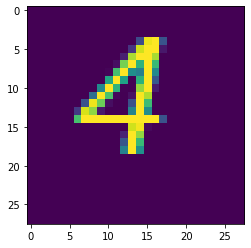

In [83]:
plt.imshow(array_test_image_1[0][:,:28,0])

# Predicting splitted image

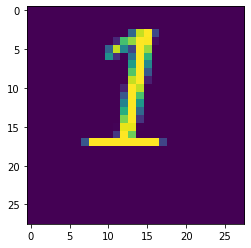

In [84]:
plt.imshow(array_test_image_1[0][:,28:56,0])

In [85]:
model.predict_classes(array_test_image_1[:, :,28:56,])

array([1], dtype=int64)

In [86]:
array_test_image_1[:, :,:28,].shape

(1, 28, 28, 1)

# Function to generate sample like data(composed from mnist numbers)

In [87]:
def generate_1x4_image(num_of_images, num_of_digits):
    list_of_images = []
    actual_classes = []
    for im in range(num_of_images):
        rand_indexes = np.random.randint(28000, size=(num_of_digits))
        long_image  = X_train[rand_indexes[0]][:,:,0]
        image_labels =[ Y_train[index] for index in rand_indexes]
        for ind in range(1,num_of_digits):
            long_image  = np.concatenate((long_image, X_train[rand_indexes[ind]][:,:,0]), axis=1)
        actual_classes.append(image_labels)
        list_of_images.append(long_image)
    return np.array(list_of_images), actual_classes

In [88]:
# If you want to create some test data, then run this cell
# Pass to the function number of test images, and amount of numbers each image will contain
gen_images, gen_images_labels = generate_1x4_image(20, 4)

In [89]:
gen_images.shape

(20, 28, 112)

# Saving generated images to the folder

In [90]:
for im in range(20):
    save_image_name = "".join(list(map(lambda x: str(x), gen_images_labels[im])))
    save_image = (((gen_images[im] - gen_images[im].min()) /\
                   (gen_images[im].max() - gen_images[im].min())) * 255.9).astype(np.uint8)
    save_image = Image.fromarray(save_image)
    save_path = "GeneratedTestImages/"+save_image_name+".png"
    save_image.save(save_path)

# Functions to split whole image, and to predict whole image

In [91]:
def split_image(image_array, num_of_digits):
    """Function splits the whole image into several images - 1 image for each digit
       Takes: image_array - (1, 28, 28*num_of_digits, 1)
       returns (num_of_images, 28, 28, 1) array"""
    
    new_array = image_array.copy().reshape(num_of_digits, 28, 28, 1)
    for im in range(num_of_digits):
        new_array[im][:,:,0] = image_array[0][:,28*im:28*(im+1), 0]# separating imput image into N images
    return new_array


def predict_full_image(image_path):
    """Function predicts all numbers on input image, in order from left to right"""
    
    # Openning image
    input_image = Image.open(image_path)
    # Converting it into numpy array, each value is in range (0, 255)
    image_array = np.array(input_image, dtype = 'float32')
    # Normalizing image
    image_array = image_array / 255.
    image_shape = image_array.shape
    if(image_shape[0] > image_shape[1]): # Image is looks like column of numbers
        image_array = np.rot90(image_array)
        image_shape = image_array.shape
    # Reshaping from (28, 28*num_digits) to (1, 28, 28*num_digits,1)
    image_array = image_array.reshape(1, 28, image_shape[1],1)
    num_of_digits = image_shape[1] // 28
    # Reshaping from (1,28, 28*num_digits,1) to (num_digits, 28, 28,1)
    splitted_images = split_image(image_array, num_of_digits)
    # Predicting result
    answer = model.predict_classes(splitted_images)
    answer = "".join(str(x) for x in answer)
    return(answer)

# Some tests

In [92]:
predict_full_image("C:/Users/AndriiHura/Desktop/4973.png")

'9985'

In [93]:
predict_full_image("images/00009.png")

'4770'

In [94]:
example_images = os.listdir("images")

In [95]:
for image in example_images:
    path = "images/"+image
    print(predict_full_image(path))

4146
2978
3161
2796
8129
6528
2176
2407
6851
4770


In [30]:
# for image in example_images:
#     path = "images/"+image
#     plt.imshow((path))

In [43]:
def get_all_images(example_images):
    images_array = np.zeros((40, 28, 28, 1))
    i = 0
    for image in example_images:
        path = "images/"+image
        # Openning image
        input_image = Image.open(path)
        # Converting it into numpy array, each value is in range (0, 255)
        image_array = np.array(input_image, dtype = 'float32')
        # Normalizing image
        image_array = image_array / 255.
        image_shape = image_array.shape
        if(image_shape[0] > image_shape[1]): # Image is looks like column of numbers
            image_array = np.rot90(image_array)
            image_shape = image_array.shape
        # Reshaping from (28, 28*num_digits) to (1, 28, 28*num_digits,1)
        image_array = image_array.reshape(1, 28, image_shape[1],1)
        num_of_digits = image_shape[1] // 28
        # Reshaping from (1,28, 28*num_digits,1) to (num_digits, 28, 28,1)
        splitted_images = split_image(image_array, num_of_digits)
        images_array[i:i+4, :, :, :] = splitted_images
        i += 4
    return images_array

In [45]:
example_images_array = get_all_images(example_images)

In [47]:
example_images_array.shape

(40, 28, 28, 1)

In [55]:
example_images_labels = np.array([4, 1, 4, 6,   
                                  2, 9, 7, 8,   
                                  3, 1, 6, 1,   
                                  2, 7, 9, 6,  
                                  8, 1, 2, 9,  
                                  6, 5, 2, 8,  
                                  2, 1, 7, 6,
                                  2, 4, 0, 7,
                                  6, 8, 5, 1,
                                  4, 7, 7, 0
                                  ])

9


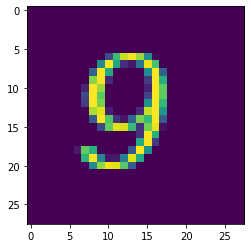

In [57]:
plt.imshow(example_images_array[5, :, :, 0])
print(example_images_labels[5])

In [60]:
import collections

In [61]:
collections.Counter(example_images_labels)

Counter({4: 4, 1: 6, 6: 6, 2: 6, 9: 3, 7: 6, 8: 4, 3: 1, 5: 2, 0: 2})

In [62]:
from keras.preprocessing.image import ImageDataGenerator

In [63]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(X_train)

In [65]:
datagen.flow

<bound method ImageDataGenerator.flow of <keras.preprocessing.image.ImageDataGenerator object at 0x000001EBA4535D48>>

In [66]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [67]:
model.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [71]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

NameError: name 'ReduceLROnPlateau' is not defined

In [70]:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=5)

Epoch 1/5


ValueError: Error when checking target: expected dense_4 to have shape (10,) but got array with shape (1,)